In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
import matplotlib.pyplot as plt
import h5py
import wandb
import random


# Configure Keras to use GPU
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)



2024-04-08 17:15:45.048505: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-08 17:15:45.080898: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-08 17:15:45.080927: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-08 17:15:45.081819: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-08 17:15:45.087082: I tensorflow/core/platform/cpu_feature_guar

In [2]:



with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
    ls = list(hdf.keys())
    images = hdf.get('images')
    boxes = hdf.get('boxes')
    images = np.array(images)
    boxes = np.array(boxes)


In [3]:


image_normalized = (images + 1e-9) / 9.26
normalized_boxes = boxes / [1, 64, 64, 64, 64]

images_np = image_normalized

probabilities = np.array(normalized_boxes[:, :, :-4])
probabilities = tf.expand_dims(probabilities, axis=1)
boxes_np = np.array(normalized_boxes[:, :, 1:])
boxes_np = tf.expand_dims(boxes_np, axis=1)
batch_size = 128
dataset = tf.data.Dataset.from_tensor_slices((images_np, {'x_prob_reshape': probabilities, 'x_boxes_reshape': boxes_np}))
dataset = dataset.shuffle(buffer_size=10000).batch(batch_size)




# total_items = 10000
# train_size = int(total_items * 0.6)
# val_size = total_items - train_size

# # Splitting the dataset
# train_dataset = dataset.take(train_size)
# val_dataset = dataset.take(val_size)


# train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
# train_dataset = train_dataset.batch(batch_size)
# val_dataset = val_dataset.batch(batch_size) 

    
    
    
   

2024-04-08 17:15:53.344951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21932 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:68:00.0, compute capability: 8.6


In [4]:
 
    

    
input_shape = (64,64,1)
num_classes = 280
num_coordinates = 4

x_input = layers.Input(shape=input_shape)
#Layer 1
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x_input)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 
x = layers.Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
#Layer 2
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, kernel_size=3, padding='same', activation='relu')(x)
#Layer 3
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, kernel_size=3, padding='same', activation='relu')(x)
#Layer 4
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(512, kernel_size=3, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
#Layer 5
x = layers.Conv2D(256, kernel_size=5, padding='same', activation='relu')(x)
x = layers.MaxPool2D()(x)
x = layers.BatchNormalization()(x) 


x = layers.Flatten()(x)
# Probability output
x_prob = layers.Dense(num_classes, activation='sigmoid', name='x_prob')(x)
x_prob_reshape = layers.Reshape((-1, num_classes, 1), name='x_prob_reshape')(x_prob)

# Bounding box output
x_boxes = layers.Dense(num_classes * num_coordinates, activation='sigmoid', name='x_boxes')(x)
x_boxes_reshape = layers.Reshape((-1, num_classes, num_coordinates), name='x_boxes_reshape')(x_boxes)


model = tf.keras.models.Model(x_input, [x_prob_reshape, x_boxes_reshape])
optimizer = tf.keras.optimizers.Adam(learning_rate=3e-5) 
model.compile(optimizer= optimizer, loss= {'x_prob_reshape': tf.keras.losses.BinaryCrossentropy(), 'x_boxes_reshape':tf.keras.losses.MeanSquaredError()}, metrics={'x_prob_reshape': 'accuracy'} )
num_epochs = 100
        
#         # Fit the model with both training and validation datasets
# model.fit(train_dataset, 
#                   epochs=num_epochs, 
#                   validation_data=val_dataset, 
#                   )


In [ ]:

        #Fit the model with both training and validation datasets
model.fit(dataset, 
                  epochs=num_epochs
                  
                  )

In [5]:
loaded_model = tf.keras.models.load_model("/home/m3-learning/Documents/Research Data/Derrick's Object Detection/Models/M11overfittedmodel3variant.h5")

Evaluation

In [23]:
# import numpy as np

# def compute_iou(box1, box2):
#     """Compute the Intersection Over Union of two bounding boxes."""
#     # Determine the coordinates of the intersection rectangle
#     x_left = max(box1[0], box2[0])
#     y_top = max(box1[1], box2[1])
#     x_right = min(box1[2], box2[2])
#     y_bottom = min(box1[3], box2[3])

#     if x_right < x_left or y_bottom < y_top:
#         return 0.0

#     intersection_area = (x_right - x_left) * (y_bottom - y_top)
#     box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
#     box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
#     iou = intersection_area / float(box1_area + box2_area - intersection_area)
#     return iou
# def precision_recall_at_iou_threshold(predicted_boxes, ground_truth_boxes, iou_threshold=0.2):
#     """Calculate precision and recall at a given IoU threshold."""
#     true_positives = 0
#     false_positives = 0
#     false_negatives = len(ground_truth_boxes)

#     for pred_box in predicted_boxes:
#         match_found = False
#         for gt_box in ground_truth_boxes:
#             iou = compute_iou(pred_box, gt_box)
#             if iou >= iou_threshold:
#                 true_positives += 1
#                 false_negatives -= 1
#                 match_found = True
#                 break  # Assume each gt box can only match with one predicted box
#         if not match_found:
#             false_positives += 1

#     precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
#     recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
#     return precision, recall

# def extract_ground_truth_boxes(gt_data):
#     """
#     Extract the ground truth bounding boxes from the ground truth data.

#     Parameters:
#     - gt_data: The ground truth data for a single image, structured as a numpy array where the first column indicates
#                the presence of an object and the next four columns are the bounding box coordinates.

#     Returns:
#     - A list of bounding boxes where each box is represented as [x_min, y_min, x_max, y_max].
#     """
#     gt_boxes = []
#     for row in gt_data:
#         # Check if the object is present
#         if row[0] == 1.0:
#             # Extract the bounding box coordinates
#             box = row[1:]
#             gt_boxes.append(box)
#     return gt_boxes


# def extract_boxes(predictions, probability_threshold=0.2):
#     """
#     Extract bounding boxes based on the probability threshold.
    
#     predictions: A tuple containing two elements; the first is the probability output of the model,
#     and the second is the bounding boxes output of the model.
#     probability_threshold: Threshold to filter bounding boxes based on their probabilities.
    
#     Returns a list of extracted bounding boxes that exceed the probability threshold.
#     """
#     prob_predictions, box_predictions = predictions
#     extracted_boxes = []
    
#     # Assuming the shape of prob_predictions is (batch_size, 1, num_classes, 1)
#     # and the shape of box_predictions is (batch_size, 1, num_classes, num_coordinates)
#     # Adjust indices if your model output structure differs
#     for class_index in range(prob_predictions.shape[2]):
#         if prob_predictions[0, class_index, 0] >= probability_threshold:
#             # Extract and denormalize the bounding box here if necessary
#             box = box_predictions[0,  class_index, :]
#             extracted_boxes.append(box)  # Convert to numpy array if not already
            
#     return extracted_boxes

# def evaluate_model(model, dataset, iou_threshold=0.2):
#     all_precisions = []
#     all_recalls = []

#     for inputs, targets in dataset:
#         output = model.predict(inputs)
#         for i in range(len(inputs)):
#             # Corrected call to extract_boxes
#             pred_boxes = extract_boxes((output[0][i], output[1][i]), probability_threshold=0.2)
            
#             # Extract ground truth bounding boxes
#             gt_boxes = extract_ground_truth_boxes(targets['x_boxes_reshape'][i].numpy().squeeze())
            
#             # Evaluate precision and recall for the current set of predictions and ground truth
#             precision, recall = precision_recall_at_iou_threshold(pred_boxes, gt_boxes, iou_threshold=iou_threshold)
#             all_precisions.append(precision)
#             all_recalls.append(recall)

#     # Compute overall metrics
#     mean_precision = np.mean (all_precisions)
#     mean_recall = np.mean(all_recalls)
#     print(f"Mean Precision: {mean_precision}, Mean Recall: {mean_recall}")

In [11]:
dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))


dataset = dataset.batch(10000)
inputs,targets = next(iter(dataset))
output = loaded_model.predict(inputs)

313/313 [==============================] - 2s 8ms/step


In [25]:


def compute_iou(box1, box2):
    """Compute the Intersection Over Union of two bounding boxes."""
    # Determine the coordinates of the intersection rectangle
    x_left = max(box1[0], box2[0])
    y_top = max(box1[1], box2[1])
    x_right = min(box1[2], box2[2])
    y_bottom = min(box1[3], box2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    iou = intersection_area / float(box1_area + box2_area - intersection_area)
    return iou
# def compute_iou_values(predicted_boxes, ground_truth_boxes):
#     """Compute IoU values for each pair of predicted and ground truth boxes."""
#     iou_values = []

#     for pred_box in predicted_boxes:
#         best_iou = 0
#         for gt_box in ground_truth_boxes:
#             iou = compute_iou(pred_box, gt_box)
#             if iou > best_iou:
#                 best_iou = iou
#         if best_iou > 0:
#             iou_values.append(best_iou)

#     return iou_values


def precision_recall_at_iou_threshold(predicted_boxes, ground_truth_boxes, iou_threshold=0.1):
    """Calculate and print IoU values alongside precision and recall at a given IoU threshold."""
    true_positives = 0
    false_positives = 0
    false_negatives = len(ground_truth_boxes)
    iou_values = []  # Store IoU values for analysis

    for pred_box in predicted_boxes:
        match_found = False
        for gt_box in ground_truth_boxes:
            iou = compute_iou(pred_box, gt_box)
            if iou > 0:  # Print or store IoU values greater than 0
                print("IoU:", iou)  # Print IoU value
                iou_values.append(iou)  # Optionally store IoU value
            if iou >= iou_threshold:
                true_positives += 1
                false_negatives -= 1
                match_found = True
                break
        if not match_found:
            false_positives += 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    return precision, recall, iou_values  # Return IoU values along with precision and recall


In [31]:


# # Assume compute_iou and precision_recall_at_iou_threshold functions are defined as above

# # Example data
# predicted_boxes = [
#     [0.1, 0.2, 0.5, 0.6],
#     [0.15, 0.25, 0.55, 0.65]
# ]
# ground_truth_boxes = [
#     [0.12, 0.22, 0.52, 0.62]
# ]

# Evaluate model
precision, recall, iou_values = precision_recall_at_iou_threshold(output[1][6,0,:,:], targets['x_boxes_reshape'][6,0,:,:], iou_threshold=0.1)

# Print results
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print("IoU Values:", iou_values)


Precision: 0.0
Recall: 0.0
IoU Values: []


In [19]:

    





# def evaluate_model(model, dataset, iou_threshold=0.5):
#     all_precisions = []
#     all_recalls = []

#     for images, labels in dataset:
#         probabilities, boxes = model.predict(images)
#         # Process model outputs here: convert probabilities to binary indicators, extract bounding boxes, etc.
#         # This depends on your model output format and how you've decided to threshold/interpret probabilities

#         for i in range(len(images)):
#             pred_boxes = extract_boxes(boxes[i], probabilities[i])  # You'll need to implement this based on your model output structure
#             gt_boxes = labels['x_boxes_reshape'][i].numpy()  # Adjust based on actual label structure
#             precision, recall = precision_recall_at_iou_threshold(pred_boxes, gt_boxes, iou_threshold=iou_threshold)
#             all_precisions.append(precision)
#             all_recalls.append(recall)

#     # Compute overall metrics
#     mean_precision = np.mean(all_precisions)
#     mean_recall = np.mean(all_recalls)
#     print(f"Mean Precision: {mean_precision}, Mean Recall: {mean_recall}")

# def evaluate_model(model, dataset, iou_threshold=0.5):
#     all_precisions = []
#     all_recalls = []

#     for images, labels in dataset:
#         probabilities, boxes = model.predict(images)
#         for i in range(len(images)):
#             # Corrected call to extract_boxes
#             pred_boxes = extract_boxes((probabilities['x_prob_reshape'][i], boxes[i]), probability_threshold=0.5)
            
#             # Extract ground truth bounding boxes
#             gt_boxes = extract_ground_truth_boxes(labels['x_boxes_reshape'][i].numpy())
            
#             # Evaluate precision and recall for the current set of predictions and ground truth
#             precision, recall = precision_recall_at_iou_threshold(pred_boxes, gt_boxes, iou_threshold=iou_threshold)
#             all_precisions.append(precision)
#             all_recalls.append(recall)

#     # Compute overall metrics
#     mean_precision = np.mean(all_precisions)
#     mean_recall = np.mean(all_recalls)
#     print(f"Mean Precision: {mean_precision}, Mean Recall: {mean_recall}")


In [12]:
# dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))


# dataset = dataset.batch(10000)
# inputs,targets = next(iter(dataset))
# output = loaded_model.predict(inputs)

313/313 [==============================] - 3s 8ms/step


In [87]:
# true_labels = targets['x_boxes_reshape']
# predicted_labels = output[1]
# from sklearn.metrics import precision_score, recall_score, f1_score

# # Example: Flatten arrays if they are in matrix form
# true_labels_flat = true_labels
# predicted_labels_flat = predicted_labels

# # Precision, Recall, and F1 Score
# precision = precision_score(true_labels, predicted_labels, average='binary')
# recall = recall_score(true_labels, predicted_labels, average='binary')
# f1 = f1_score(true_labels, predicted_labels, average='binary')

# print(f"Precision: {precision}\nRecall: {recall}\nF1 Score: {f1}")


In [11]:
# dataset = tf.data.Dataset.from_tensor_slices((images_np,{'x_prob_reshape':probabilities,'x_boxes_reshape':boxes_np}))

# # # Assuming dataset has 10,000 examples and we want an 80/20 split
# # total_items = 10000
# # train_size = int(total_items * 0.6)
# # # val_size = total_items - train_size

# # # Splitting the dataset
# # train_dataset = dataset.take(train_size)
# # # val_dataset = dataset.skip(train_size)


# # # train_dataset = train_dataset.shuffle(buffer_size=train_size,reshuffle_each_iteration=True)
# # train_dataset = train_dataset.batch(6000)
# # inputs,targets = next(iter(train_dataset))
# dataset = dataset.batch(10000)
# inputs,targets = next(iter(dataset))
# output = model.predict(inputs)

### Testing

In [86]:
# import h5py
# import numpy as np
# import tensorflow as tf
# import matplotlib.pyplot as plt

# # Assuming your test dataset is structured similarly to your training dataset
# with h5py.File('TrainingData5zeroes.h5', 'r') as hdf:
#     test_images = hdf.get('images')
#     test_boxes = hdf.get('boxes')
#     test_images = np.array(test_images[:999])
#     test_boxes = np.array(test_boxes[:999])

# # Normalizing test data
# test_images_normalized = (test_images + 1e-9) / 9.26
# test_normalized_boxes = test_boxes / [1, 64, 64, 64, 64]

# # Preparing test dataset
# test_probabilities = np.array(test_normalized_boxes[:, :, :-4])
# test_probabilities = tf.expand_dims(test_probabilities, axis=1)
# test_boxes_np = np.array(test_normalized_boxes[:, :, 1:])
# test_boxes_np = tf.expand_dims(test_boxes_np, axis=1)
# test_dataset = tf.data.Dataset.from_tensor_slices((test_images_normalized, {'x_prob_reshape': test_probabilities, 'x_boxes_reshape': test_boxes_np}))
# test_dataset = test_dataset.batch(128)  # Use the same batch size as in training

# # Evaluate the model
# # Evaluate the model on the test dataset
# eval_results = model.evaluate(test_dataset)

# # Printing evaluation results
# print("Evaluation results (Overall loss, loss per output, and metrics per output):")
# for metric_name, metric_value in zip(model.metrics_names, eval_results):
#     print(f"{metric_name}: {metric_value}")

# # Since the model has multiple outputs and potentially multiple metrics, you may have a structure like this:
# # [overall_loss, loss_x_prob_reshape, loss_x_boxes_reshape, metric1_x_prob_reshape, metric1_x_boxes_reshape, ...]

# # If you specifically want to print out just the overall test loss and a particular metric, such as the accuracy for the probability predictions, you can do so by accessing the appropriate indices. 
# # Note: Adjust the indices based on your actual model's metrics.
# print(f"Overall Test Loss: {eval_results[0]}")
# print(f"Accuracy for probability predictions (x_prob_reshape): {eval_results[3]}") # Assuming the accuracy for `x_prob_reshape` is the first metric after the losses.


# # Generate predictions for a subset of the test dataset
# # for test_images_batch, _ in test_dataset.take(1):  # Taking a single batch
# #     predictions = model.predict(test_images_batch)
# #     probabilities_pred, boxes_pred = predictions

# #     # Visualizing predictions for the first few images in the batch
# #     num_images_to_display = 5
# #     fig, axs = plt.subplots(1, num_images_to_display, figsize=(20, 5))
# #     for i in range(num_images_to_display):
# #         axs[i].imshow(test_images_batch[i].squeeze(), cmap='gray')  # Assuming grayscale images
# #         # Here you could also overlay the true and predicted bounding boxes
# #         # This part is left as an exercise since it depends on your specific needs and data format
# #     plt.show()


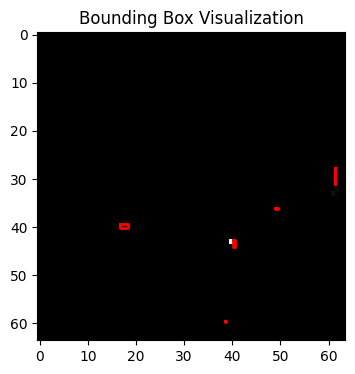

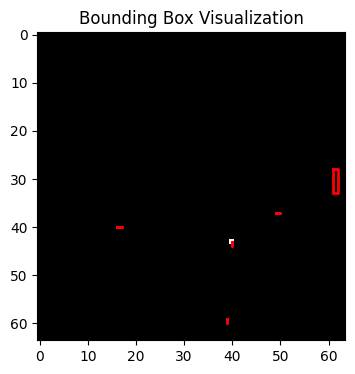

In [16]:
def visualize_bounding_boxes(image, probability_vector, bounding_box_coordinates, threshold=0.9):
    """
    Visualizes bounding boxes on an image based on a probability vector.

    Parameters:
    - image: A 3D tensor representing the image.
    - probability_vector: A 1D tensor representing the probabilities associated with bounding boxes.
    - bounding_box_coordinates: A 2D tensor representing bounding box coordinates.
    - threshold: Probability threshold for visualization.

    Returns:
    None (displays the image with bounding boxes).
    """
    # Convert to NumPy arrays for easier handling
    image_np = image
    prob_vector_np = probability_vector
    bbox_coordinates_np = bounding_box_coordinates
   # Denormalize image if necessary (adjust based on your normalization method)
    denormalized_image = image_np  # Modify if normalization was applied during training

    # Visualize the image
    plt.figure(figsize=(4, 4))
    plt.imshow(denormalized_image, cmap='gray')
    plt.title("Bounding Box Visualization")

    # Plot bounding boxes based on probability threshold
    for i in range(len(prob_vector_np)):
        prob = prob_vector_np[i]
        bbox = bbox_coordinates_np[i]
        if prob > threshold:
            # Denormalize bounding box coordinates if necessary
            denormalized_bbox = bbox  # Modify if normalization was applied during training
            y1, x1, y2, x2 = denormalized_bbox
            plt.plot([x1, x2, x2, x1, x1],[y1, y1, y2, y2, y1],
                     
                     color='r', linewidth=2, label='Bounding Box')

   






   
    plt.show()

t = np.random.randint(0,400)


visualize_bounding_boxes(tf.convert_to_tensor(inputs[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(output[1][t,0,:,:])*[64,64,64,64]) ##myprediction
visualize_bounding_boxes(tf.convert_to_tensor(image_normalized[t]), probabilities.numpy()[t].squeeze(), tf.convert_to_tensor(boxes_np[t,0,:,:])*[64,64,64,64]) ##myprediction



